In [3]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[(GoodSubs['FD_exclusion']<=2)&(GoodSubs['ABS_exclusion']<=2)&(GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)


HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                         len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))

We collected and downloaded data from 43 subjects
 There are 34 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 15 with a 20 channel headcoil


## Compute TSNR if Not Already

In [5]:
prep_dir='%s/derivatives/fmriprep'%(project_dir)
f_list = [prep_dir+'/%s/func/%s_task-sharedreward_acq-%s_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'%(row['sub']                                                                                            ,row['sub'],
                                                                                                    row['acq']) for index,row in subs.iterrows()]
from nilearn.image import math_img

for img in tqdm(f_list):  

    me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
    mb=int(re.search('_acq-mb(.*?)me',img).group(1))
    sub=re.search('func/sub-(.*?)_task',img).group(1)

    if not os.path.exists('../derivatives/tsnr/sub-%s_acq-mb%sme%s_tsnr.nii.gz' %(sub,mb,me)):
        print('sub: %s Multiband: %s Multiecho: %s'%(sub,mb,me))
        print('does not exist')
        mask = '../derivatives/fmriprep/sub-%s/func/sub-%s_task-sharedreward_acq-mb%sme%s_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'%(sub,sub,mb,me)

        nifti_masker = NiftiMasker(mask_img=mask)
        x=nifti_masker.fit_transform(img)
        img=nifti_masker.inverse_transform(x)
        tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)
        tsnr_img.to_filename('../derivatives/tsnr/sub-%s_acq-mb%sme%s_tsnr.nii.gz' %(sub,mb,me))


sub: 10136 Multiband: 3 Multiecho: 4
does not exist
sub: 10136 Multiband: 3 Multiecho: 1
does not exist
sub: 10136 Multiband: 6 Multiecho: 4
does not exist
sub: 10136 Multiband: 1 Multiecho: 4
does not exist
sub: 10136 Multiband: 6 Multiecho: 1
does not exist
sub: 10136 Multiband: 1 Multiecho: 1
does not exist


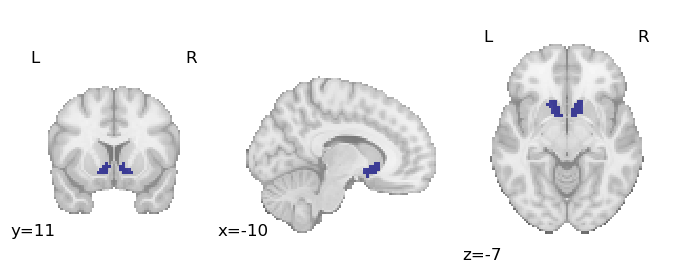

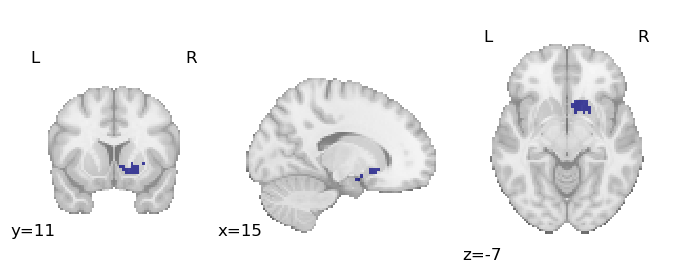

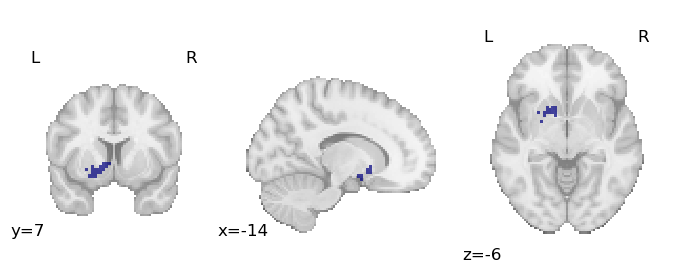

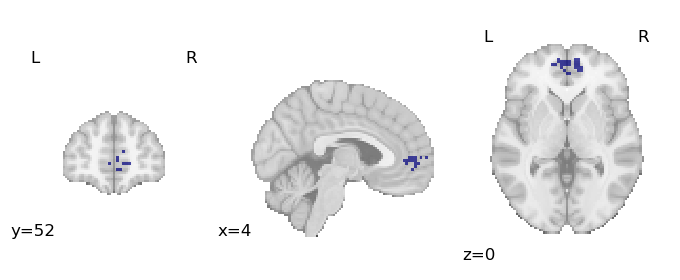

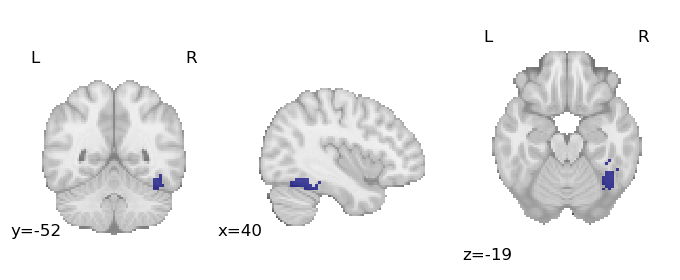

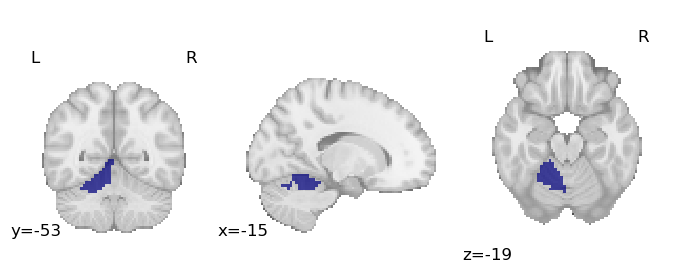

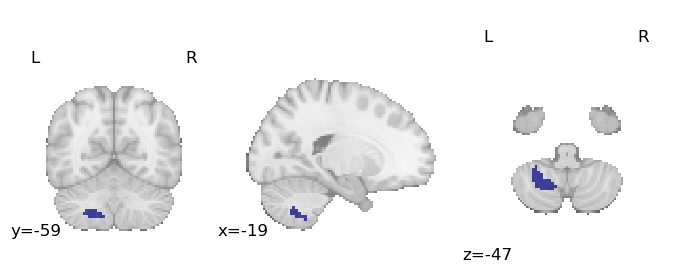

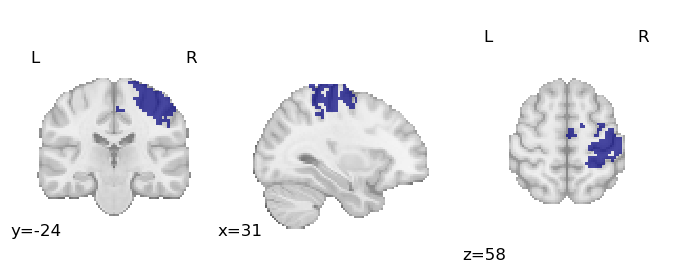

In [7]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/fROI-FFA_cname-StrVsComp_zstat-1.nii.gz'
    sCerb_mask='../masks/fROI-sCerb_cname-LeftVsRight_zstat-1.nii.gz'
    iCerb_mask='../masks/fROI-iCerb_cname-LeftVsRight_zstat-1.nii.gz'
    motor_mask='../masks/fROI-Motor_cname-LeftVsRight_zstat-1.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        plotting.plot_roi(mask,draw_cross=False)
        plt.show()

In [8]:
flist=['../derivatives/tsnr/%s_acq-%s_tsnr.nii.gz'%(row['sub'],row['acq']) for index,row in subs.iterrows()]
#display(flist)
data=[]
img_list=[]
if os.path.exists("../derivatives/TSNRinfo.tsv"):
    df=pd.read_csv("../derivatives/TSNRinfo.tsv",sep='\t')
else:
    for img in tqdm(flist):
        start = time.time()
        tsnr_img=img
        #print(img)
        sub=re.search('tsnr/sub-(.*?)_acq',img).group(1)
        me=int(re.search('_acq-mb[0-7]me(.*?)_',img).group(1))
        mb=int(re.search('_acq-mb(.*?)me',img).group(1))
        #sub=re.search('func/sub-(.*?)_task',img).group(1)
        #print('sub: %s Multiband: %s Multiecho: %s'%(sub,mb,me))
        #tsnr_img = image.math_img('img.mean(axis=3) / img.std(axis=3)', img=img)

        for mask in mask_list:
            nifti_masker = NiftiMasker(mask_img=mask)
            mask_name=re.search('ROI-(.*)_cname',mask).group(1)
            x=nifti_masker.fit_transform(tsnr_img)
            img=nifti_masker.inverse_transform(x)
            data.append([sub,mb,me,mask_name,np.mean(x.flatten())])
    df=pd.DataFrame(data=data,columns=['sub','MB','ME','Region','TSNR'])
    df.to_csv("../derivatives/TSNRinfo.tsv",sep="\t",index=False)
df['sub']='sub-'+df['sub'].astype(str)

['../derivatives/tsnr/sub-10017_acq-mb6me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb1me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb3me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb3me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb1me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10017_acq-mb6me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb3me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb6me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb1me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb6me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb1me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10024_acq-mb3me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb1me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb6me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb1me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb6me4_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035_acq-mb3me1_tsnr.nii.gz',
 '../derivatives/tsnr/sub-10035

100%|█████████████████████████████████████████| 202/202 [09:33<00:00,  2.84s/it]


In [11]:
#df=pd.read_csv("../derivatives/TSNRinfo.tsv",sep='\t')
df['acq']='mb'+df['MB'].astype(str)+'me'+df['ME'].astype(str)
#df['sub']='sub-'+df['sub'].astype(str)
display(df.head())
display(subs.head())
df2 = pd.merge(df, subs, on=["sub","acq"])
df2

,sub,MB,ME,Region,TSNR,acq
0,sub-10017,6,4,VS,31.702188,mb6me4
1,sub-10017,6,4,RVS,28.980915,mb6me4
2,sub-10017,6,4,LVS,26.821964,mb6me4
3,sub-10017,6,4,vmPFC,40.178303,mb6me4
4,sub-10017,6,4,FFA,50.127300,mb6me4


,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64
2,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64
4,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64


,sub,MB,ME,Region,TSNR,acq,index,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,sub-10017,6,4,VS,31.702188,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,sub-10017,6,4,RVS,28.980915,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
2,sub-10017,6,4,LVS,26.821964,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
3,sub-10017,6,4,vmPFC,40.178303,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
4,sub-10017,6,4,FFA,50.127300,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,sub-12042,1,4,vmPFC,45.126385,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1612,sub-12042,1,4,FFA,58.243114,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1613,sub-12042,1,4,sCerb,61.147240,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1614,sub-12042,1,4,iCerb,56.616749,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20


,sub,MB,ME,Region,TSNR,acq,index,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil
0,sub-10017,6,4,VS,31.702188,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
1,sub-10017,6,4,RVS,28.980915,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
2,sub-10017,6,4,LVS,26.821964,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
3,sub-10017,6,4,vmPFC,40.178303,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
4,sub-10017,6,4,FFA,50.127300,mb6me4,181,1,0.680831,0.086961,False,False,False,HeadNeck_64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,sub-12042,1,4,vmPFC,45.126385,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1612,sub-12042,1,4,FFA,58.243114,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1613,sub-12042,1,4,sCerb,61.147240,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20
1614,sub-12042,1,4,iCerb,56.616749,mb1me4,34,0,0.384643,0.091856,False,False,False,HeadNeck_20


VS
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              17.1851  
Min. group size:  6       Log-Likelihood:     -345.9755
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    20.105    1.899 10.587 0.000 16.383 23.827
MB            0.694    0.367  1.889 0.059 -0.026  1.414
ME            7.858    0.493 15.931 0.000  6.891  8.825
MB:ME        -1.165    0.126 -9.251 0.000 -1.412 -0.918
Group Var    29.225    2.821                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              9.5247   
Min. group size:  5       Log-Likelihood:     -244.8785
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   19.417    1.808  10.741 0.000 15.874 22.960
MB           0.955    0.313   3.053 0.002  0.342  1.568
ME           7.634    0.421  18.138 0.000  6.809  8.459
MB:ME       -1.624    0.107 -15.248 0.000 -1.833 -1.415
Group Var   25.959    3.698                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       202           Method:                   REML     
No. Groups:             34            Scale:                    13.8744  
Min. group size:        5             Log-Likelihood:           -594.2257
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     19.406    2.023   9.594 0.000 15.442 23.371
HeadCoil[T.HeadNeck_64]        0.699    2.688   0.260 0.795 -4.569  5.967
MB                             0.957    0.378   2.535 0.011  0.217  1.697
MB:HeadCoil[T.HeadNeck_64]    -0.263    0.501  -0.525 0.599 -1.246  0.719
ME                             7.637    0.508  15.036 0.000  6.642  8.633
ME:HeadCoil[T.HeadNeck_64]     0.221    0.674   0.328 0.743 -1.100  1.542
MB:ME                         -1.625    0.129 -12.639 0.000 -1.877 -1.373
MB:ME:HeadCoil[T.HeadNeck_64]  0.459    0.171   2.681 0.007  0.124  0.795
Group Var                     27.791    2.212                            
=========================================================================

"""

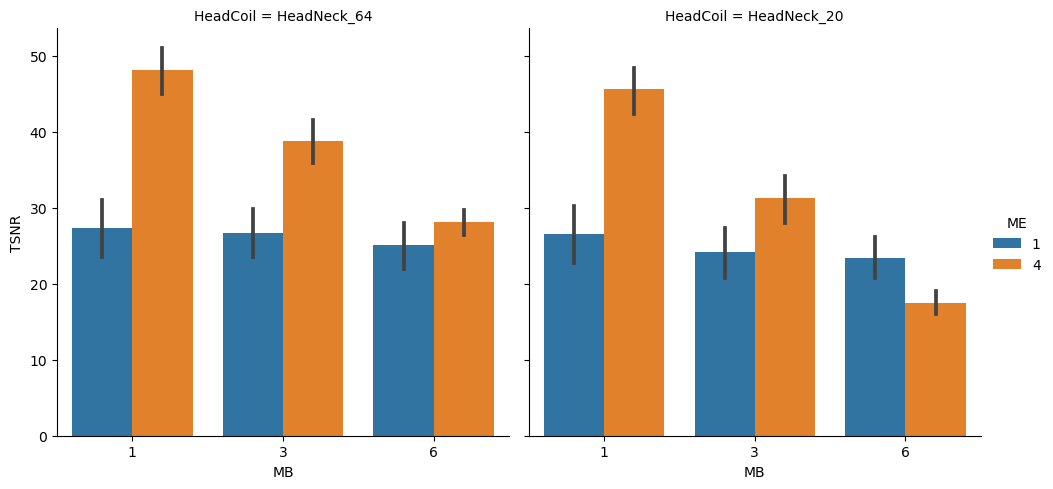

RVS
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              6.0822   
Min. group size:  6       Log-Likelihood:     -294.9613
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   28.960    1.363  21.249 0.000 26.289 31.632
MB          -0.082    0.218  -0.375 0.708 -0.510  0.346
ME           4.578    0.293  15.599 0.000  4.002  5.153
MB:ME       -0.777    0.075 -10.370 0.000 -0.924 -0.630
Group Var   21.386    3.310                            
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              5.5351   
Min. group size:  5       Log-Likelihood:     -219.1703
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   28.709    1.239  23.171 0.000 26.281 31.138
MB          -0.250    0.238  -1.047 0.295 -0.717  0.218
ME           4.516    0.321  14.076 0.000  3.887  5.145
MB:ME       -1.158    0.081 -14.263 0.000 -1.317 -0.999
Group Var    9.630    1.858                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       202           Method:                   REML     
No. Groups:             34            Scale:                    5.8459   
Min. group size:        5             Log-Likelihood:           -515.2764
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     28.712    1.424  20.169 0.000 25.922 31.502
HeadCoil[T.HeadNeck_64]        0.248    1.893   0.131 0.896 -3.463  3.959
MB                            -0.250    0.245  -1.022 0.307 -0.731  0.230
MB:HeadCoil[T.HeadNeck_64]     0.169    0.326   0.518 0.605 -0.469  0.807
ME                             4.516    0.330  13.695 0.000  3.869  5.162
ME:HeadCoil[T.HeadNeck_64]     0.062    0.438   0.141 0.888 -0.796  0.920
MB:ME                         -1.158    0.083 -13.876 0.000 -1.321 -0.994
MB:ME:HeadCoil[T.HeadNeck_64]  0.381    0.111   3.424 0.001  0.163  0.599
Group Var                     16.246    1.949                            
=========================================================================

"""

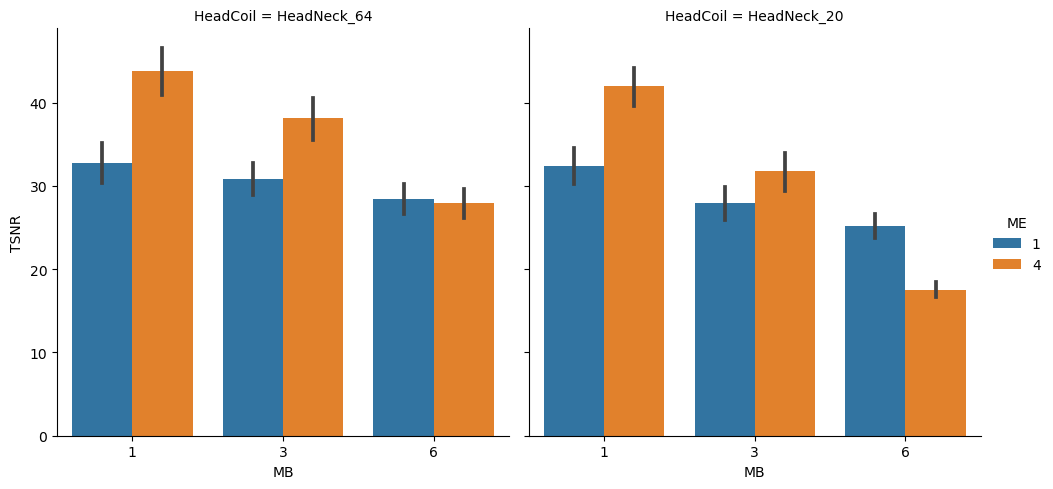

LVS
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              8.8018   
Min. group size:  6       Log-Likelihood:     -308.6648
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    24.388    1.341 18.181 0.000 21.759 27.017
MB            0.257    0.263  0.978 0.328 -0.258  0.772
ME            5.447    0.353 15.431 0.000  4.756  6.139
MB:ME        -0.897    0.090 -9.946 0.000 -1.073 -0.720
Group Var    14.061    1.908                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              9.1670   
Min. group size:  5       Log-Likelihood:     -239.8738
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   22.082    1.570  14.067 0.000 19.005 25.158
MB           0.467    0.307   1.522 0.128 -0.135  1.068
ME           6.015    0.413  14.569 0.000  5.206  6.824
MB:ME       -1.339    0.104 -12.819 0.000 -1.544 -1.135
Group Var   14.775    2.229                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       202           Method:                   REML     
No. Groups:             34            Scale:                    8.9597   
Min. group size:        5             Log-Likelihood:           -548.5597
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     22.082    1.550  14.242 0.000 19.043 25.120
HeadCoil[T.HeadNeck_64]        2.307    2.059   1.120 0.263 -1.728  6.342
MB                             0.467    0.303   1.539 0.124 -0.128  1.062
MB:HeadCoil[T.HeadNeck_64]    -0.210    0.403  -0.521 0.602 -1.000  0.580
ME                             6.015    0.408  14.737 0.000  5.215  6.815
ME:HeadCoil[T.HeadNeck_64]    -0.567    0.542  -1.047 0.295 -1.629  0.494
MB:ME                         -1.339    0.103 -12.966 0.000 -1.542 -1.137
MB:ME:HeadCoil[T.HeadNeck_64]  0.443    0.138   3.216 0.001  0.173  0.712
Group Var                     14.373    1.450                            
=========================================================================

"""

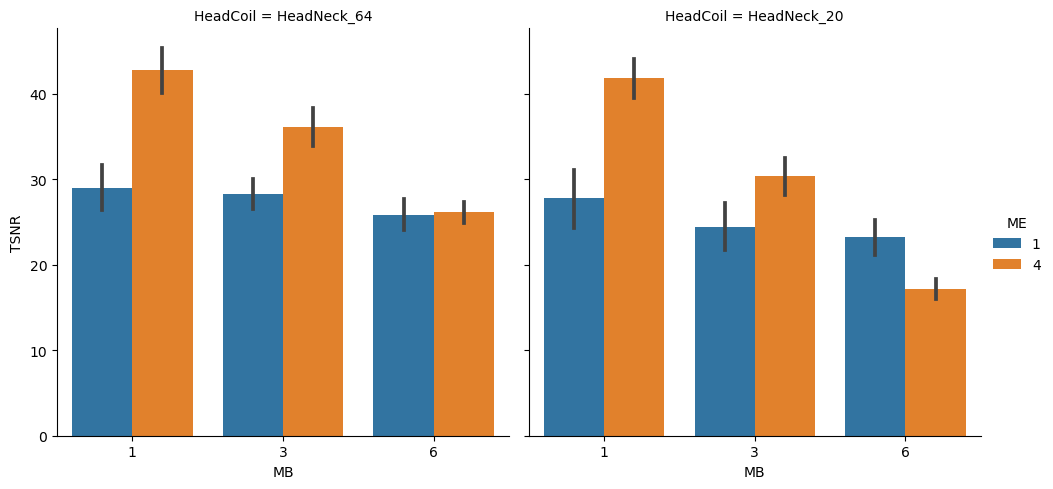

vmPFC
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              40.8501  
Min. group size:  6       Log-Likelihood:     -386.7120
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    34.215    2.535 13.498 0.000 29.247 39.183
MB           -0.150    0.566 -0.265 0.791 -1.260  0.960
ME            4.410    0.761  5.799 0.000  2.920  5.901
MB:ME        -0.398    0.194 -2.048 0.041 -0.778 -0.017
Group Var    28.682    2.024                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              16.5019  
Min. group size:  5       Log-Likelihood:     -267.3823
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    30.556    2.326 13.138 0.000 25.998 35.114
MB           -0.689    0.412 -1.673 0.094 -1.496  0.118
ME            3.322    0.554  5.997 0.000  2.237  4.408
MB:ME        -0.435    0.140 -3.104 0.002 -0.710 -0.160
Group Var    41.183    4.484                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        202          Method:                  REML     
No. Groups:              34           Scale:                   30.3298  
Min. group size:         5            Log-Likelihood:          -661.7879
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     30.553    2.677 11.415 0.000 25.307 35.799
HeadCoil[T.HeadNeck_64]        3.662    3.551  1.031 0.302 -3.297 10.622
MB                            -0.689    0.558 -1.235 0.217 -1.783  0.405
MB:HeadCoil[T.HeadNeck_64]     0.539    0.741  0.728 0.467 -0.914  1.992
ME                             3.328    0.751  4.432 0.000  1.856  4.800
ME:HeadCoil[T.HeadNeck_64]     1.082    0.997  1.086 0.277 -0.871  3.036
MB:ME                         -0.435    0.190 -2.291 0.022 -0.808 -0.063
MB:ME:HeadCoil[T.HeadNeck_64]  0.038    0.253  0.148 0.882 -0.459  0.534
Group Var                     34.093    1.948                           
========================================================================

"""

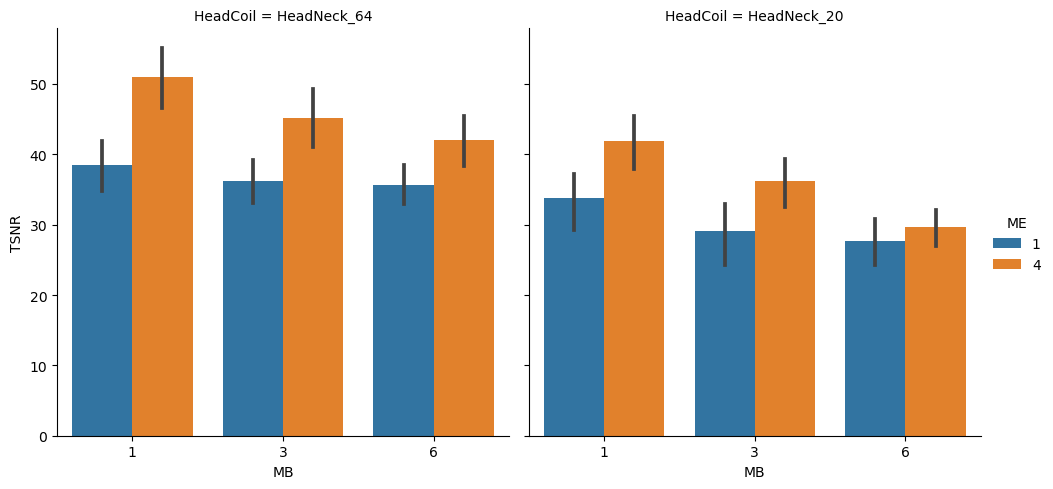

FFA
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              46.8136  
Min. group size:  6       Log-Likelihood:     -396.0249
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    37.467    2.801 13.379 0.000 31.978 42.956
MB            0.094    0.606  0.156 0.876 -1.094  1.282
ME            4.576    0.814  5.621 0.000  2.981  6.172
MB:ME        -0.629    0.208 -3.023 0.003 -1.036 -0.221
Group Var    41.976    2.652                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              14.8412  
Min. group size:  5       Log-Likelihood:     -259.0220
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    33.270    1.933 17.214 0.000 29.482 37.059
MB           -0.424    0.390 -1.086 0.277 -1.189  0.341
ME            4.990    0.525  9.500 0.000  3.961  6.020
MB:ME        -0.993    0.133 -7.467 0.000 -1.253 -0.732
Group Var    20.114    2.431                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        202          Method:                  REML     
No. Groups:              34           Scale:                   32.9929  
Min. group size:         5            Log-Likelihood:          -668.0917
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     33.287    2.735 12.170 0.000 27.926 38.648
HeadCoil[T.HeadNeck_64]        4.180    3.627  1.152 0.249 -2.929 11.289
MB                            -0.427    0.582 -0.734 0.463 -1.568  0.714
MB:HeadCoil[T.HeadNeck_64]     0.522    0.773  0.674 0.500 -0.994  2.037
ME                             4.986    0.783  6.366 0.000  3.451  6.520
ME:HeadCoil[T.HeadNeck_64]    -0.409    1.039 -0.394 0.694 -2.446  1.628
MB:ME                         -0.992    0.198 -5.005 0.000 -1.380 -0.603
MB:ME:HeadCoil[T.HeadNeck_64]  0.363    0.264  1.376 0.169 -0.154  0.881
Group Var                     32.407    1.806                           
========================================================================

"""

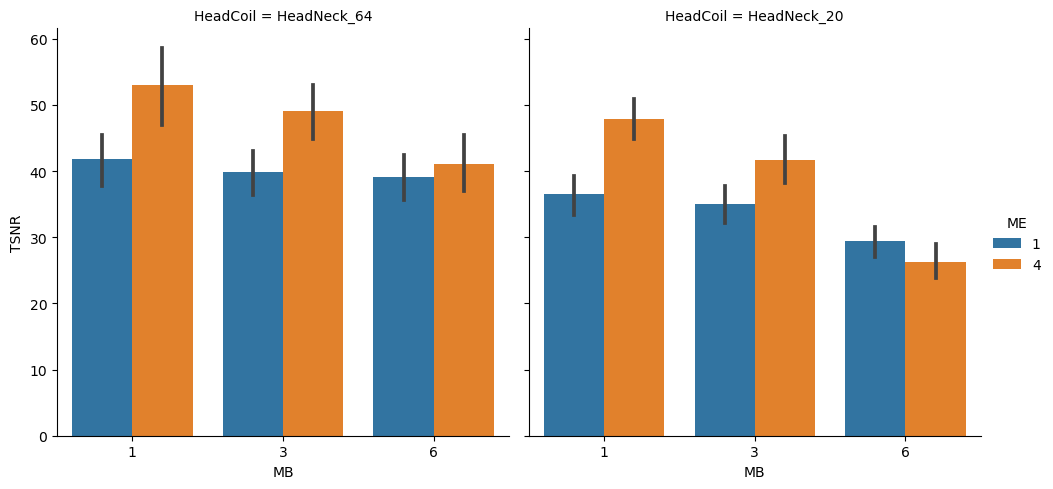

sCerb
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              11.6350  
Min. group size:  6       Log-Likelihood:     -322.1337
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    41.014    1.475 27.811 0.000 38.124 43.905
MB           -0.133    0.302 -0.440 0.660 -0.725  0.459
ME            4.304    0.406 10.605 0.000  3.509  5.100
MB:ME        -0.714    0.104 -6.893 0.000 -0.918 -0.511
Group Var    14.719    1.780                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              9.0010   
Min. group size:  5       Log-Likelihood:     -236.6892
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
            Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept   40.080    1.451  27.615 0.000 37.235 42.925
MB          -0.568    0.304  -1.869 0.062 -1.164  0.028
ME           5.022    0.409  12.278 0.000  4.220  5.824
MB:ME       -1.187    0.104 -11.463 0.000 -1.390 -0.984
Group Var    9.821    1.562                            
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                  MixedLM       Dependent Variable:       TSNR     
No. Observations:       202           Method:                   REML     
No. Groups:             34            Scale:                    10.4966  
Min. group size:        5             Log-Likelihood:           -559.7554
Max. group size:        6             Converged:                Yes      
Mean group size:        5.9                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     40.082    1.591  25.191 0.000 36.963 43.200
HeadCoil[T.HeadNeck_64]        0.932    2.111   0.442 0.659 -3.205  5.070
MB                            -0.569    0.328  -1.732 0.083 -1.212  0.075
MB:HeadCoil[T.HeadNeck_64]     0.436    0.436   0.999 0.318 -0.419  1.290
ME                             5.022    0.442  11.368 0.000  4.156  5.887
ME:HeadCoil[T.HeadNeck_64]    -0.717    0.586  -1.224 0.221 -1.867  0.432
MB:ME                         -1.187    0.112 -10.614 0.000 -1.406 -0.968
MB:ME:HeadCoil[T.HeadNeck_64]  0.472    0.149   3.169 0.002  0.180  0.764
Group Var                     12.577    1.210                            
=========================================================================

"""

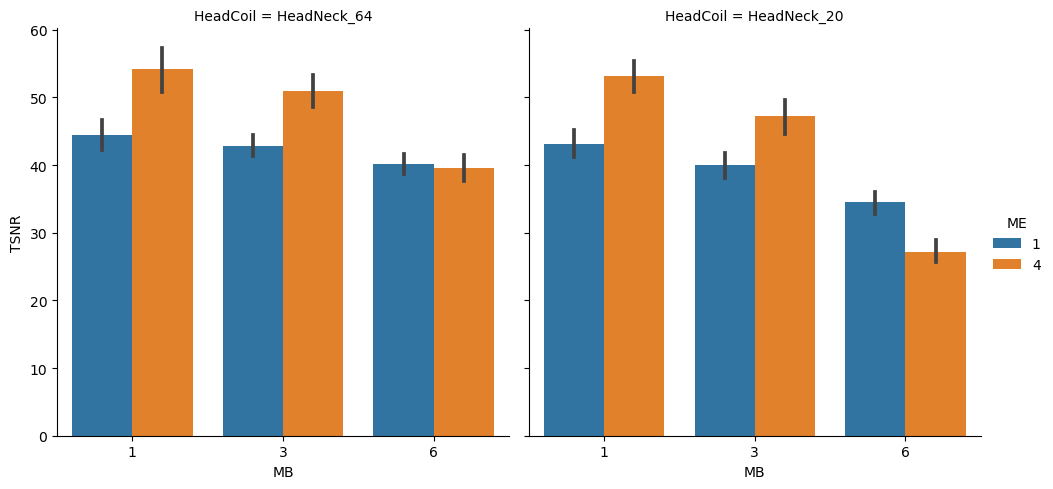

iCerb
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              9.6164   
Min. group size:  6       Log-Likelihood:     -317.0133
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    38.940    1.545 25.202 0.000 35.912 41.969
MB            0.136    0.275  0.496 0.620 -0.402  0.675
ME            4.672    0.369 12.661 0.000  3.949  5.395
MB:ME        -0.643    0.094 -6.819 0.000 -0.827 -0.458
Group Var    23.372    2.935                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              33.8786  
Min. group size:  5       Log-Likelihood:     -295.3979
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    33.206    3.079 10.784 0.000 27.171 39.241
MB            0.002    0.590  0.003 0.998 -1.155  1.158
ME            4.723    0.794  5.951 0.000  3.167  6.279
MB:ME        -1.223    0.201 -6.090 0.000 -1.617 -0.830
Group Var    60.226    4.686                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        202          Method:                  REML     
No. Groups:              34           Scale:                   20.1029  
Min. group size:         5            Log-Likelihood:          -629.9086
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     33.205    2.424 13.697 0.000 28.454 37.957
HeadCoil[T.HeadNeck_64]        5.735    3.221  1.780 0.075 -0.578 12.048
MB                             0.002    0.454  0.004 0.997 -0.889  0.893
MB:HeadCoil[T.HeadNeck_64]     0.134    0.604  0.223 0.824 -1.049  1.317
ME                             4.723    0.611  7.726 0.000  3.525  5.922
ME:HeadCoil[T.HeadNeck_64]    -0.052    0.811 -0.064 0.949 -1.642  1.539
MB:ME                         -1.223    0.155 -7.906 0.000 -1.527 -0.920
MB:ME:HeadCoil[T.HeadNeck_64]  0.581    0.206  2.817 0.005  0.177  0.985
Group Var                     39.492    2.614                           
========================================================================

"""

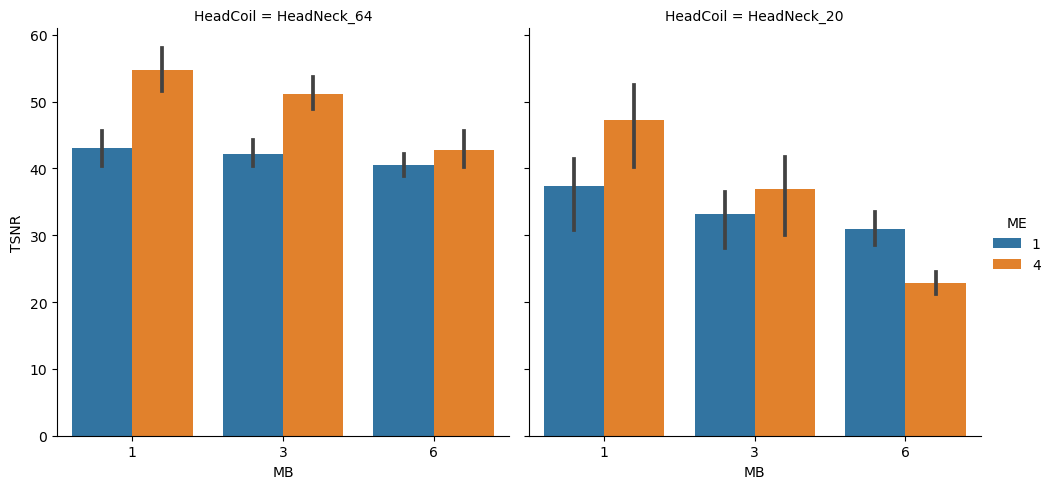

Motor
HeadNeck_64


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 114     Method:             REML     
No. Groups:       19      Scale:              44.4378  
Min. group size:  6       Log-Likelihood:     -387.5835
Max. group size:  6       Converged:          Yes      
Mean group size:  6.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    46.379    2.509 18.483 0.000 41.461 51.297
MB            0.408    0.591  0.691 0.489 -0.749  1.566
ME            2.797    0.793  3.526 0.000  1.242  4.351
MB:ME        -0.616    0.203 -3.040 0.002 -1.013 -0.219
Group Var    18.022    1.390                           
=======================================================

"""

HeadNeck_20


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: TSNR     
No. Observations: 88      Method:             REML     
No. Groups:       15      Scale:              11.2719  
Min. group size:  5       Log-Likelihood:     -247.5008
Max. group size:  6       Converged:          Yes      
Mean group size:  5.9                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    42.736    1.686 25.348 0.000 39.431 46.040
MB           -0.526    0.340 -1.546 0.122 -1.193  0.141
ME            3.436    0.458  7.505 0.000  2.538  4.333
MB:ME        -0.946    0.116 -8.161 0.000 -1.173 -0.718
Group Var    15.357    2.133                           
=======================================================

"""

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                   MixedLM      Dependent Variable:      TSNR     
No. Observations:        202          Method:                  REML     
No. Groups:              34           Scale:                   30.1056  
Min. group size:         5            Log-Likelihood:          -651.8543
Max. group size:         6            Converged:               Yes      
Mean group size:         5.9                                            
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     42.786    2.444 17.509 0.000 37.997 47.576
HeadCoil[T.HeadNeck_64]        3.592    3.237  1.110 0.267 -2.752  9.937
MB                            -0.535    0.556 -0.962 0.336 -1.625  0.555
MB:HeadCoil[T.HeadNeck_64]     0.943    0.738  1.277 0.201 -0.504  2.391
ME                             3.418    0.748  4.570 0.000  1.952  4.884
ME:HeadCoil[T.HeadNeck_64]    -0.621    0.993 -0.626 0.531 -2.567  1.324
MB:ME                         -0.943    0.189 -4.981 0.000 -1.314 -0.572
MB:ME:HeadCoil[T.HeadNeck_64]  0.327    0.252  1.297 0.195 -0.167  0.821
Group Var                     16.804    1.091                           
========================================================================

"""

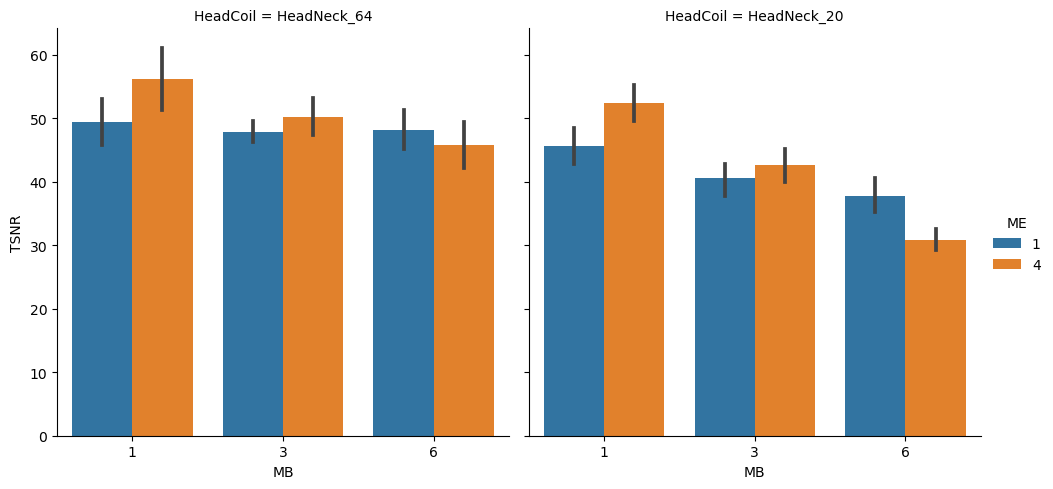

In [13]:
import matplotlib.pyplot as plt
#import statsmodels.api as sm
import statsmodels.formula.api as smf

#df=pd.read_csv("../derivatives/TSNRinfo.tsv",sep='\t')
display(df2)
for region in df2['Region'].unique():
    print(region)
    plt_df=df2[df2['Region']==region]
    for HC in plt_df['HeadCoil'].unique():
        mod_df = plt_df[plt_df['HeadCoil'] == HC]
        print(HC)
        res=smf.mixedlm('TSNR ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
        display(res.summary())
    res=smf.mixedlm('TSNR ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
    display(res.summary())
    sns.catplot(x='MB',y='TSNR',hue='ME',col='HeadCoil',data=plt_df,kind='bar')
    plt.show()

In [89]:
plt_df

,sub,MB,ME,Region,TSNR,acq
0,sub-10017,6,4,VS,31.702188,mb6me4
8,sub-10017,1,4,VS,56.226482,mb1me4
16,sub-10017,3,1,VS,29.278024,mb3me1
24,sub-10017,3,4,VS,45.055321,mb3me4
32,sub-10017,1,1,VS,27.372550,mb1me1
...,...,...,...,...,...,...
1528,sub-12042,3,1,VS,30.707053,mb3me1
1536,sub-12042,6,4,VS,19.370708,mb6me4
1544,sub-12042,1,1,VS,35.245289,mb1me1
1552,sub-12042,6,1,VS,30.471955,mb6me1
